In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Para formatação dos eixos, se necessário

# Exemplo de valores (pode ser substituído por input do usuário)
# Mesma EDO dos exemplos anteriores para consistência
f_str_exemplo = str('2*x*y')
x_exemplo = 1
y_exemplo = 2
h_exemplo = 0.1
interacoes_exemplo = 27


In [2]:

def resolver_edo_ralston(f_str, x_inicial, y_inicial, h_passo, num_total_iteracoes):
    """
    Resolve uma EDO de primeira ordem dy/dx = f(x,y) usando o método de Ralston.

    Args:
        f_str (str): A equação dy/dx = f(x,y) como string.
        x_inicial (float/int): Valor inicial de x (x0).
        y_inicial (float/int): Valor inicial de y (y0).
        h_passo (float/int): Tamanho do passo (h).
        num_total_iteracoes (int): Número de iterações a serem calculadas APÓS o ponto inicial.

    Returns:
        tuple: Contendo:
            - df (pd.DataFrame): DataFrame com os resultados das iterações.
            - equacao_info (str): String descrevendo a equação fornecida.
            - condicoes_info (str): String descrevendo as condições iniciais.
            - passo_info (str): String descrevendo o passo h.
            - num_iteracoes_info (str): String descrevendo o número de iterações.
        Retorna (None, error_message, None, None, None) em caso de erro na conversão
        de input ou na interpretação da função.
    """

    try:
        x0_global = float(x_inicial)
        y0_global = float(y_inicial)
        h = float(h_passo)
        num_iteracoes = int(num_total_iteracoes)
    except ValueError:
        error_msg = "Erro: Entrada inválida. Certifique-se de que os valores numéricos (x_inicial, y_inicial, h_passo, num_total_iteracoes) estão corretos."
        return None, error_msg, None, None, None

    try:
        allowed_names = {"x": None, "y": None, "math": math}

        def func(x_eval, y_eval):
            return eval(f_str, {"__builtins__": {}}, {**allowed_names, "x": x_eval, "y": y_eval})
        func(x0_global, y0_global)  # Teste inicial
    except Exception as e:
        error_msg = f"Erro ao interpretar a função f(x,y) ('{f_str}'): {e}\n" \
            "Certifique-se de que a equação usa 'x' e 'y' como variáveis.\n" \
            "Para funções matemáticas, use o prefixo 'math.', por exemplo, 'math.sin(x)'."
        return None, error_msg, None, None, None

    equacao_info = f"Equação fornecida: dy/dx = {f_str}"
    condicoes_info = f"Condições iniciais: x0 = {x0_global}, y0 = {y0_global}"
    passo_info = f"Passo (h): {h}"
    num_iteracoes_info = f"Número de iterações após o ponto inicial: {num_iteracoes}"

    iter_col = []
    x_col = []
    y_col = []
    k1_col = []
    k2_col = []
    erro_col = []

    x_i = x0_global
    y_i = y0_global

    # Iteração 0 (ponto inicial)
    iter_col.append(0)
    x_col.append(x_i)
    y_col.append(y_i)

    # k1 e k2 são calculados para o ponto (x_i, y_i) atual
    # Estes k1 e k2 da linha 'Iter. i' serão usados para calcular y na linha 'Iter. i+1'
    k1_atual = func(x_i, y_i)
    k1_col.append(k1_atual)

    # Fórmula de Ralston para k2
    k2_atual = func(x_i + (3.0 * h) / 4.0, y_i + (3.0 * k1_atual * h) / 4.0)
    k2_col.append(k2_atual)
    erro_col.append(float('nan'))

    # Loop para as iterações seguintes
    for i in range(1, num_iteracoes + 1):
        y_anterior_neste_passo = y_i  # y_i da iteração anterior (y_{n-1})

        # k1 e k2 da iteração anterior (calculados no final do loop anterior ou na inicialização)
        k1_do_passo_anterior = k1_atual
        k2_do_passo_anterior = k2_atual

        # Fórmula de Ralston para y_{i+1}
        # y_{i+1} = y_i + (k1/3 + 2k2/3)h
        y_i = y_i + (k1_do_passo_anterior / 3.0 +
                     (2.0 * k2_do_passo_anterior) / 3.0) * h

        x_i = x0_global + i * h

        iter_col.append(i)
        x_col.append(x_i)
        y_col.append(y_i)

        # Calcula k1 e k2 para ESTA iteração (x_i, y_i atuais)
        k1_atual = func(x_i, y_i)
        k1_col.append(k1_atual)

        k2_atual = func(x_i + (3.0 * h) / 4.0, y_i +
                        (3.0 * k1_atual * h) / 4.0)
        k2_col.append(k2_atual)

        erro_val = abs(y_i - y_anterior_neste_passo)
        erro_col.append(erro_val)

    df = pd.DataFrame({
        'Iter.': iter_col,
        'x0': x_col,
        'y0': y_col,
        'K1': k1_col,
        'K2': k2_col,
        'ERRO |yn-yn-1|': erro_col
    })

    return df, equacao_info, condicoes_info, passo_info, num_iteracoes_info


def gerar_grafico_edo_ralston(df_resultados, titulo_grafico="Solução da EDO pelo Método de Ralston"):
    """
    Gera e exibe um gráfico da solução da EDO (y0 vs x0) e do erro
    (|yn - y_{n-1}| vs x0) a partir de um DataFrame para o método de Ralston.
    """
    if not isinstance(df_resultados, pd.DataFrame):
        print("Erro: A entrada deve ser um DataFrame do Pandas.")
        return
    required_cols = {'x0', 'y0', 'ERRO |yn-yn-1|'}
    if not required_cols.issubset(df_resultados.columns):
        print(f"Erro: O DataFrame deve conter as colunas {required_cols}.")
        return
    if df_resultados.empty:
        print("Erro: O DataFrame está vazio, nada para plotar.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(df_resultados['x0'], df_resultados['y0'], marker='o',
             # Cor diferente
             linestyle='-', color='purple', label='$y_n$ (Solução Ralston)')
    plt.plot(df_resultados['x0'], df_resultados['ERRO |yn-yn-1|'], marker='s',
             # Cor diferente
             linestyle='--', color='brown', label='$|y_n - y_{n-1}|$ (Erro Aproximado)')

    plt.title(titulo_grafico, fontsize=16)
    plt.xlabel("$x_n$", fontsize=14)
    plt.ylabel("Valores", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    return plt



In [3]:

# --- Exemplo de uso do método de Ralston ---
dataframe_ralston, eq_info_ralston, ci_info_ralston, p_info_ralston, ni_info_ralston = resolver_edo_ralston(
    f_str_exemplo,
    x_exemplo,
    y_exemplo,
    h_exemplo,
    interacoes_exemplo
)


Solução de EDO pelo Método de Ralston
------------------------------------
Equação fornecida: dy/dx = 2*x*y
Condições iniciais: x0 = 1.0, y0 = 2.0
Passo (h): 0.1
Número de iterações após o ponto inicial: 27
------------------------------------

Resultados das Iterações:
 Iter.    x0          y0           K1           K2 ERRO |yn-yn-1|
     0 1.000      2.0000       4.0000       4.9450            NaN
     1 1.100      2.4630       5.4186       6.7431         0.4630
     2 1.200      3.0932       7.4236       9.3073         0.6302
     3 1.300      3.9611      10.2989      13.0172         0.8679
     4 1.400      5.1722      14.4822      18.4622         1.2111
     5 1.500      6.8858      20.6573      26.5704         1.7136
     6 1.600      9.3457      29.9062      38.8220         2.4599
     7 1.700     12.9307      43.9644      57.6095         3.5850
     8 1.800     18.2368      65.6525      86.8528         5.3061
     9 1.900     26.2154      99.6186     133.0629         7.9786
   

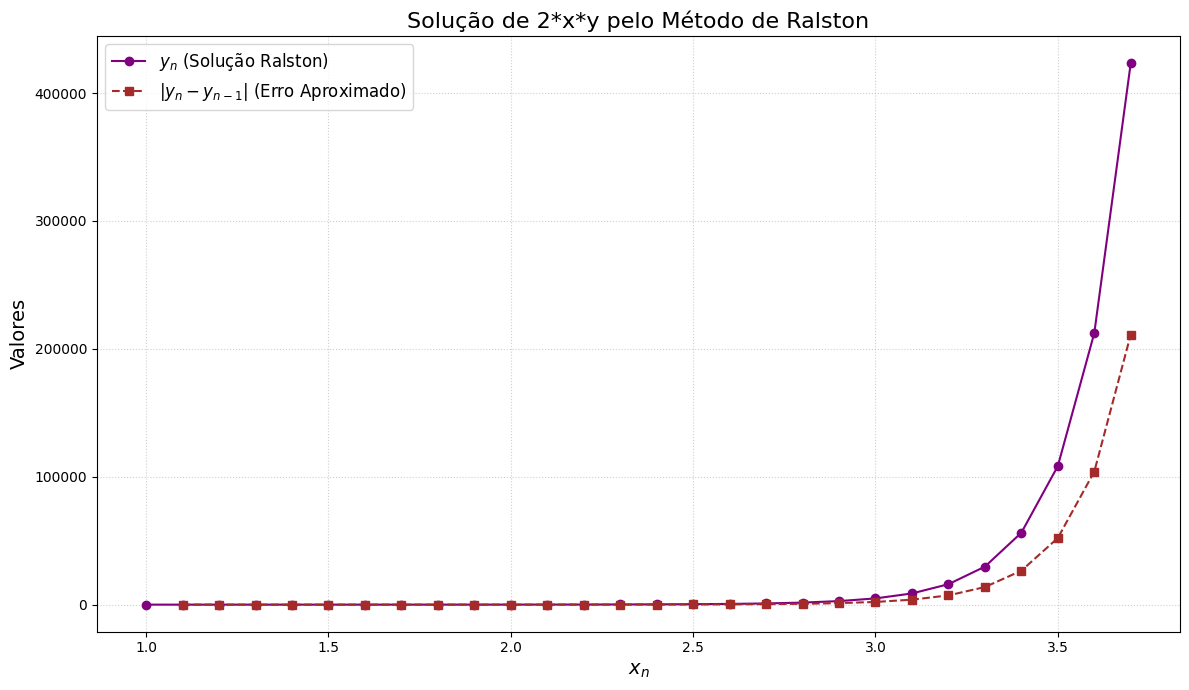

In [4]:

if dataframe_ralston is not None:
    print("Solução de EDO pelo Método de Ralston")
    print("------------------------------------")
    print(eq_info_ralston)
    print(ci_info_ralston)
    print(p_info_ralston)
    print(ni_info_ralston)
    print("------------------------------------\n")
    print("Resultados das Iterações:")

    # Formatação para o DataFrame de Ralston, baseado na imagem:
    # x0: 3 casas (1.000)
    # y0: 4 casas (2.4630)
    # K1: 4 casas (4.0000)
    # K2: 4 casas (4.9450)
    # ERRO: 4 casas (0.4630)
    formatters_ralston = {
        'x0': '{:.3f}'.format,
        'y0': '{:.4f}'.format,
        'K1': '{:.4f}'.format,
        'K2': '{:.4f}'.format,
        'ERRO |yn-yn-1|': '{:.4f}'.format
    }
    print(dataframe_ralston.to_string(index=False,
          na_rep='NaN', formatters=formatters_ralston))

    grafico_ralston = gerar_grafico_edo_ralston(
        dataframe_ralston, titulo_grafico=f"Solução de {f_str_exemplo} pelo Método de Ralston"
    )
    # grafico_ralston.show() # Descomente para exibir o gráfico
    print("\nGráfico gerado (descomente plt.show() na função ou aqui para exibir).")

else:
    print(f"Não foi possível calcular a solução: {eq_info_ralston}")

print("\n--- Exemplo com erro na equação (Ralston) ---")
dataframe_erro_ralston, msg_erro_ralston, _, _, _ = resolver_edo_ralston(
    "2*x - math.log(y*z)",  # Equação com variável 'z' não definida
    1, 2, 0.1, 3
)

In [5]:
dataframe_ralston

,Iter.,x0,y0,K1,K2,ERRO |yn-yn-1|
0,0,1.0,2.000000,4.000000e+00,4.945000e+00,NaN
1,1,1.1,2.463000,5.418600e+00,6.743078e+00,0.463000
2,2,1.2,3.093159,7.423581e+00,9.307314e+00,0.630159
3,3,1.3,3.961099,1.029886e+01,1.301716e+01,0.867940
4,4,1.4,5.172205,1.448217e+01,1.846219e+01,1.211106
5,5,1.5,6.885756,2.065727e+01,2.657041e+01,1.713551
6,6,1.6,9.345693,2.990622e+01,3.882201e+01,2.459936
7,7,1.7,12.930700,4.396438e+01,5.760950e+01,3.585008
8,8,1.8,18.236813,6.565253e+01,8.685282e+01,5.306113
9,9,1.9,26.215419,9.961859e+01,1.330629e+02,7.978606
